# 1. Import Libraries

In [24]:
import json
import os

import librosa
import librosa.display

import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [25]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "drive/My Drive/colab-notebooks/music-genre-classification-project/data/genres"
JSON_PATH = "drive/My Drive/colab-notebooks/music-genre-classification-project/data.json"
MODEL_PATH = "drive/My Drive/colab-notebooks/music-genre-classification-project/trained-model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Preparing Dataset

## 2.1 Extract and Store Data
1. Extract MFCC (Mel Frequency Cepstral Coefficients) from audio files. 
2. Label MFCC with it's respective genre. 
3. Stores extracted information in a JSON file.

In [26]:
def extract_data(dataset_path, json_path, num_segments, samples_per_track, num_mfcc=13, interval_fft=2048, hop_length=512):
    # dataset_path: path to dataset
    # json_path: path to json
    # num_mfcc: number of coefficients to extract
    # interval_fft: interval we consider to apply fast fourier transformation (number of samples)
    # hop_length: sliding window for fast fourier transformation (number of samples) to form spectrum
    # num_segments: number of segments sample tracks are divided into

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "genres": [], # list of genres
        "mfcc": [], # list of mfcc
        "labels": [] # maps mfcc to genre
    }

    samples_per_segment = int(samples_per_track / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # mfcc's created per hop length
    processed_genre = 0

    # LOOP THROUGH GENRE FILE
    for genreIndex, (directory_path, directory_name_path, filename_list) in enumerate(os.walk(dataset_path)): # loop through genre sub folders
        if directory_path is not dataset_path: # Make sure we're in genre's sub directory

            # GET GENRE
            genre = directory_path.split("/")[-1] # get genre from folder name (folder name contains genre name)
            data["genres"].append(genre)
            print(f"\nProcessing: {genre}")
            processed_num_files = 0
            total_num_files = len(filename_list)
            processed_genre = processed_genre + 1

            for filename in filename_list: # loop through audio files in genre's sub directory
                # LOAD AUDIO FILE
                file_path = os.path.join(directory_path, filename)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                processed_num_files = processed_num_files + 1

                # PRINT PROGRESS
                processed = processed_num_files*100/total_num_files
                print(f"Genres Processed: {processed_genre} | {genre} Processed: {round(processed, 2)}%")

                # LOOP THROUGH AUDIO SEGMENTS 
                for segment_index in range(num_segments):  
                    start = samples_per_segment * segment_index # calculate start sample for current segment
                    finish = start + samples_per_segment # calculate finish sample for current segment

                    # GET MFCC
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=interval_fft, hop_length=hop_length) # extract mfcc
                    mfcc = mfcc.T # transpose 

                    # MAP MFCC TO GENRE
                    if len(mfcc) == num_mfcc_vectors_per_segment: # store only mfcc feature with expected number of vectors
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(genreIndex-1)
                        # print(f"Filename: {filename} | Segment:{segment_index+1}")

                        #VIEW SPECTOGRAPH (TIME V MFCC)
                        # librosa.display.specshow(mfcc, sr=sample_rate, hop_length=hop_length)
                        # plt.xlabel("MFCC")
                        # plt.ylabel("Time")
                        # plt.colorbar()
                        # plt.show()

    return data 

## 2.2 Create JSON Data

In [27]:
SAMPLE_RATE = 22050 # measured in hertz
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION 
NUM_SEGMENTS = 10

data = extract_data(DATASET_PATH, JSON_PATH, NUM_SEGMENTS, SAMPLES_PER_TRACK)


Processing: rock
Genres Processed: 1 | rock Processed: 0.23%
Genres Processed: 1 | rock Processed: 0.45%
Genres Processed: 1 | rock Processed: 0.68%
Genres Processed: 1 | rock Processed: 0.9%
Genres Processed: 1 | rock Processed: 1.13%
Genres Processed: 1 | rock Processed: 1.35%
Genres Processed: 1 | rock Processed: 1.58%
Genres Processed: 1 | rock Processed: 1.8%
Genres Processed: 1 | rock Processed: 2.03%
Genres Processed: 1 | rock Processed: 2.25%
Genres Processed: 1 | rock Processed: 2.48%
Genres Processed: 1 | rock Processed: 2.7%
Genres Processed: 1 | rock Processed: 2.93%
Genres Processed: 1 | rock Processed: 3.15%
Genres Processed: 1 | rock Processed: 3.38%
Genres Processed: 1 | rock Processed: 3.6%
Genres Processed: 1 | rock Processed: 3.83%
Genres Processed: 1 | rock Processed: 4.05%
Genres Processed: 1 | rock Processed: 4.28%
Genres Processed: 1 | rock Processed: 4.5%
Genres Processed: 1 | rock Processed: 4.73%
Genres Processed: 1 | rock Processed: 4.95%
Genres Processed: 1

In [28]:
# save MFCCs to json file
with open(JSON_PATH, "w") as jsonFilePath:
    json.dump(data, jsonFilePath, indent=4)

# 3. Implement Convolutional Neural Network

## *Run to Use Preloaded JSON File 

In [5]:
JSON_PATH = "drive/My Drive/colab-notebooks/music-genre-classification-project/preloaded-data-10-segments.json"

## 3.1 Load Data
1. Load data from 'data.json' file
2. 'mfcc' data is loaded as input 
3. 'label' data is loaded as output/targets.

In [29]:
DATA_PATH = JSON_PATH

def load_data(data_path):
    with open(data_path, "r") as filepath:
        data = json.load(filepath)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def get_num_genres(data_path):
    with open(DATA_PATH, "r") as fp: # number of genres
        data = json.load(fp) 
    return np.array(len(data["genres"]))

## 3.2 Prepare Dataset
1. Load data and split it into train (to teach model), validation (to tweak model), and test sets (to predict).
2. Percentage of data used for testing and validation is indicated by a value between 0 and 1 stored in test_size and validation_size, respectively

In [30]:
def prepare_datasets(test_size, validation_size):
    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # X -> (mfcc, time)
    # add an axis to input sets (X -> (mfcc, time, channels))
    X_train = X_train[..., np.newaxis] # X_train -> (num_samples, mfcc, time, channels)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [31]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.1, 0.1) #0.25, 0.2

## 3.3 Build Convolutional Neural Network Model

In [32]:
def build_model(input_shape, num_genres):

    # create model
    model = keras.Sequential()

    # 1st convolution layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) # (kernel, (grid_size, grid_size), activation, input_shape)
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')) # ((grid_size, grid_size), strides, padding)
    model.add(keras.layers.BatchNormalization()) # normalizes activations in a current layer and presented to consequent layer (higher convergence and reliability)

    # 2nd convolution layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd convolution layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten()) # flatten output from a 3d array to 2d array
    model.add(keras.layers.Dense(64, activation='relu')) # Dense layer has 64 neurons
    model.add(keras.layers.Dropout(0.5))
    
    # output layer
    model.add(keras.layers.Dense(num_genres, activation='softmax')) # 

    return model

In [33]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1) # input shape (MFCC, time, channels/depth)
num_genres = 11 # get_num_genres(DATA_PATH) 

model = build_model(input_shape, num_genres)

## 3.4 Run Model

In [34]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# train model
EPOCHS = 100
BATCH_SIZE = 64
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=BATCH_SIZE, epochs=EPOCHS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

## 3.7 Plot History
1. Plot accuracy/loss for training/validation/testing set as a function of the epochs
2. Takes history of model as input

In [35]:
def plot_history(history):
    # history: Training history of model

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

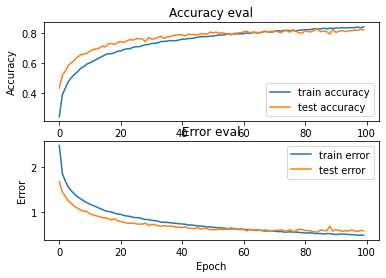

In [36]:
# plot accuracy/error for training and validation
plot_history(history)

## 3.8 Predict single sample using trained model

In [37]:
def predict(model, X, y):
    # model: Trained classifier
    # X: input
    # y: target

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (num of samples, mfcc, time, channels)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1) # outputs index of genre predicted (genre that scored the highest value)

    print(f"Target: {y} Predicted label: {predicted_index}")

## 3.9 Test Model

In [38]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc}")

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

83/83 - 0s - loss: 0.5906 - accuracy: 0.8022 - 299ms/epoch - 4ms/step

Test accuracy: 0.8022019863128662
Target: 6 Predicted label: [6]
